# Visual Feature Analyses SIM 2 - Detecting Pigs and the Swedish Chef

This notebook contains the visual feature analysis for the Similarity Modeling 2 project. The objective is to detect the presence of all pigs and the swedish chef, in a frame using visual features. These features are extracted using the methods outlined below. For the classification task, we employ a Naive Bayes algorithm as well as an XGBoost Gradient Boosting Algorithm combined with a nested cross-validation approach.




## Timesheets
**Oleksandra's timesheet**

<table>
<thead>
  <tr>
    <th>Date</th>
    <th>Task</th>
    <th>Hours</th>

  </tr>
</thead>
<tbody>
  <tr>
    <td>08.01.25</td>
    <td>Experimented with SIFT feature extraction (idea discarded)</td>
    <td>1.5 hrs</td>
  </tr>
</tbody>
</table>

**Mahmoud's timesheet:**

<table>
<thead>
  <tr>
    <th>Date</th>
    <th>Task</th>
    <th>Hours</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>10.01.2025</td>
    <td>Set up the notebook, research, and implementation of <code>extract_lbp_features</code> function </td>
    <td>3 hrs</td>
  </tr>
  <tr>
    <td>11.01.2025</td>
    <td>further experimentation, implementation of <code>extract_dct_features</code> and <code>extract_hsv_features</code> function.</td>
    <td>4 hrs</td>
  </tr>
  <tr>
    <td>12.01.2025</td>
    <td>Train Naive Bayes and XGBoost, evaluate their performance, and document the results.</td>
    <td>5 hrs</td>
  </tr>
</tbody>
</table>


In [29]:
import numpy as np
import pandas as pd

from scripts.load_data import check_and_load
from scripts.extract_video_features import extract_lbp_features, extract_dct_features, extract_hsv_features
from scripts.nested_cv import partition_feature_df

import os
from skimage.feature import local_binary_pattern
from skimage.io import imread
from skimage.color import rgb2gray, rgb2hsv
from tqdm import tqdm
from pathlib import Path
from scipy.fftpack import dct
from skimage.util import img_as_ubyte

## Data Loading

In [30]:
# # Define paths
# data_path = "../ground_truth_data/trimmed_videos"
# frames_output_dir = "../ground_truth_data/trimmed_videos/frames"
# audio_output_dir = "../ground_truth_data/trimmed_videos/audio"
# annotations_path = "../ground_truth_data/trimmed_videos"

data_path = "../ground_truth_data"
frames_output_dir = "../ground_truth_data/frames"
audio_output_dir = "../ground_truth_data/audio"
annotations_path = "../ground_truth_data"

muppet_files = {
    "Muppets-02-01-01.avi": "GroundTruth_Muppets-02-01-01.csv",
    "Muppets-02-04-04.avi": "GroundTruth_Muppets-02-04-04.csv",
    "Muppets-03-04-03.avi": "GroundTruth_Muppets-03-04-03.csv",
}

In [31]:
annotations, audio_data, frames = check_and_load(data_path, frames_output_dir, audio_output_dir, annotations_path, muppet_files)

Frames and audio are already extracted.
Loading audio segments...
Loaded 3 audio files.
Loaded audio segments for 3 videos.
Loaded frames for 3 videos.
Number of videos with frames: 3
Video 0 has 38681 frames.
Video 1 has 38706 frames.
Video 2 has 38498 frames.


## Feature Engineering

This section outlines the extraction of meaningful visual features from the video frames for the classification task. The goal is to transform raw image data into a structured format that highlights key patterns and properties essential for detecting and analyzing the presence of the pigs and the swedish chef in the videos.


### Local Binary Patterns (LBP)
LBP is a texture descriptor that captures local patterns by encoding pixel intensity relationships within a 3x3 neighborhood. It is particularly useful for identifying repetitive structures like textures or edges. We first convert the frames to grayscale to reduce computational complexity. Next, a circular LBP operator is applied to analyze a pixel's neighborhood and generate a binary pattern. Finally, we calculate a histogram of the LBP values to summarize the texture distribution for each frame.

In [32]:
#lbp_features_df = extract_lbp_features(frames) # function saves df to ../model_vars/sim2_video/lbp_feature_df.csv - change parameter output_path if needed

# load features if already computed
lbp_features_df = pd.read_csv("../model_vars/sim2_video/lbp_feature_df.csv")

lbp_features_df.shape

(115885, 12)

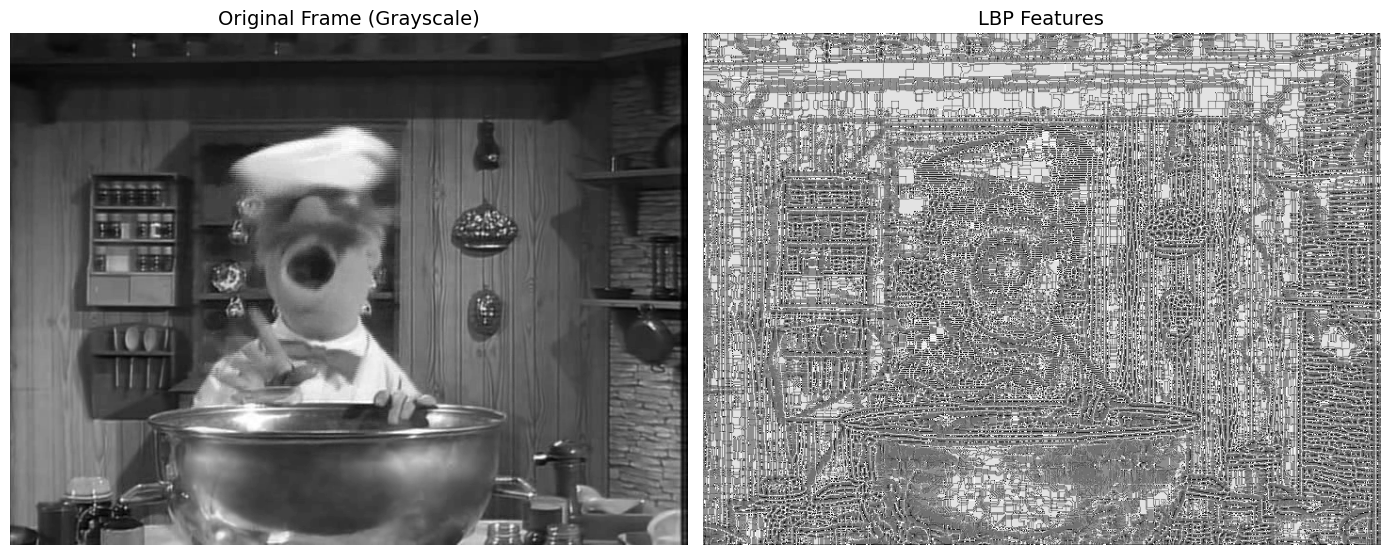

In [33]:
from scripts.extract_video_features import visualize_lbp

frame_path = "../ground_truth_data/frames\\Muppets-02-01-01_frame29336.png"  # Replace with your frame path
frame = imread(frame_path)
# Visualize lbp
visualize_lbp(frame)


### Discrete Cosine Transform (DCT)
DCT captures frequency domain information, emphasizing patterns in varying spatial frequencies. This method is commonly used in image compression and feature extraction due to its ability to retain critical information while reducing dimensionality. Similar to LBP the frames are converted to grayscale, then a 2D DCT is applied to each frame, and the top-left coefficients (low frequencies) are retained. These coefficients represent the dominant structural information in the image, ignoring fine details.

In [34]:
#dct_features_df = extract_dct_features(frames)

#load features if already computed
dct_features_df = pd.read_csv('../model_vars/sim2_video/dct_feature_df.csv')

dct_features_df.shape

(115885, 66)

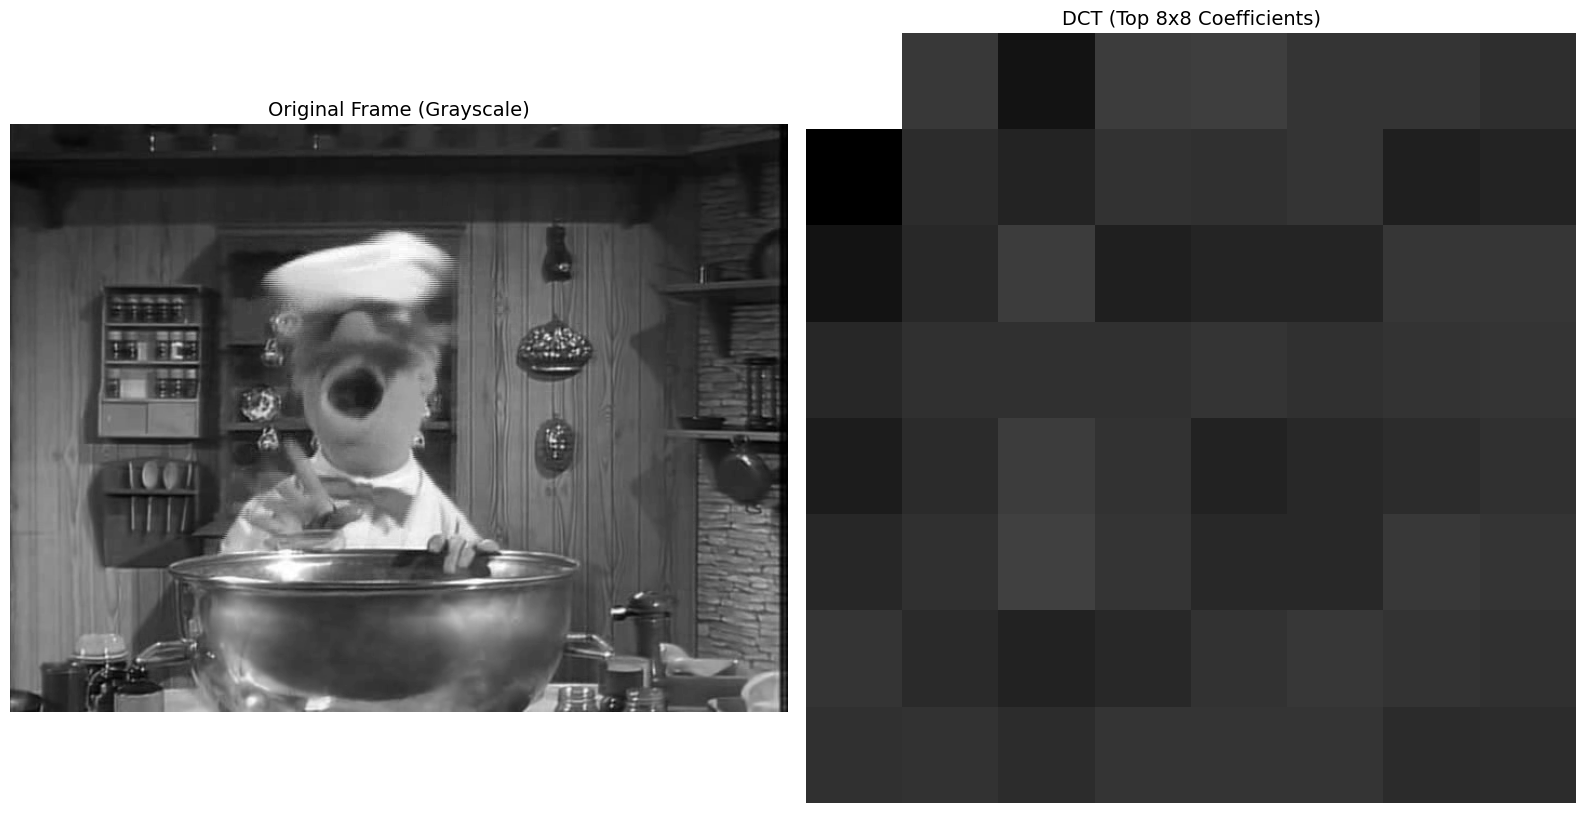

In [35]:
from scripts.extract_video_features import visualize_dct

frame_path = "../ground_truth_data/frames\\Muppets-02-01-01_frame29336.png"  # Replace with your frame path
frame = imread(frame_path)
# Visualize dct
visualize_dct(frame)

### HSV Color Histograms - supplemental
Though this technique was discussed in similarity modeling 1, we borrowed this feature engineering method, in order to make use of the colors of the chracters. HSV (Hue, Saturation, Value) provides a representation of color, separating chromatic information (hue and saturation) from intensity (value). This approach is effective in distinguishing objects based on their color characteristics - such as the pink of the pigs. We convert the frames to the HSV color space and compute histograms for each channel (H, S, and V), capturing the distribution of colors in the image. 

In [36]:
# Extract Color Histogram features
#hsv_feature_df = extract_hsv_features(frames)

#load features if already computed
hsv_feature_df = pd.read_csv('../model_vars/sim2_video/hsv_feature_df.csv')
 
hsv_feature_df.shape

(115885, 50)

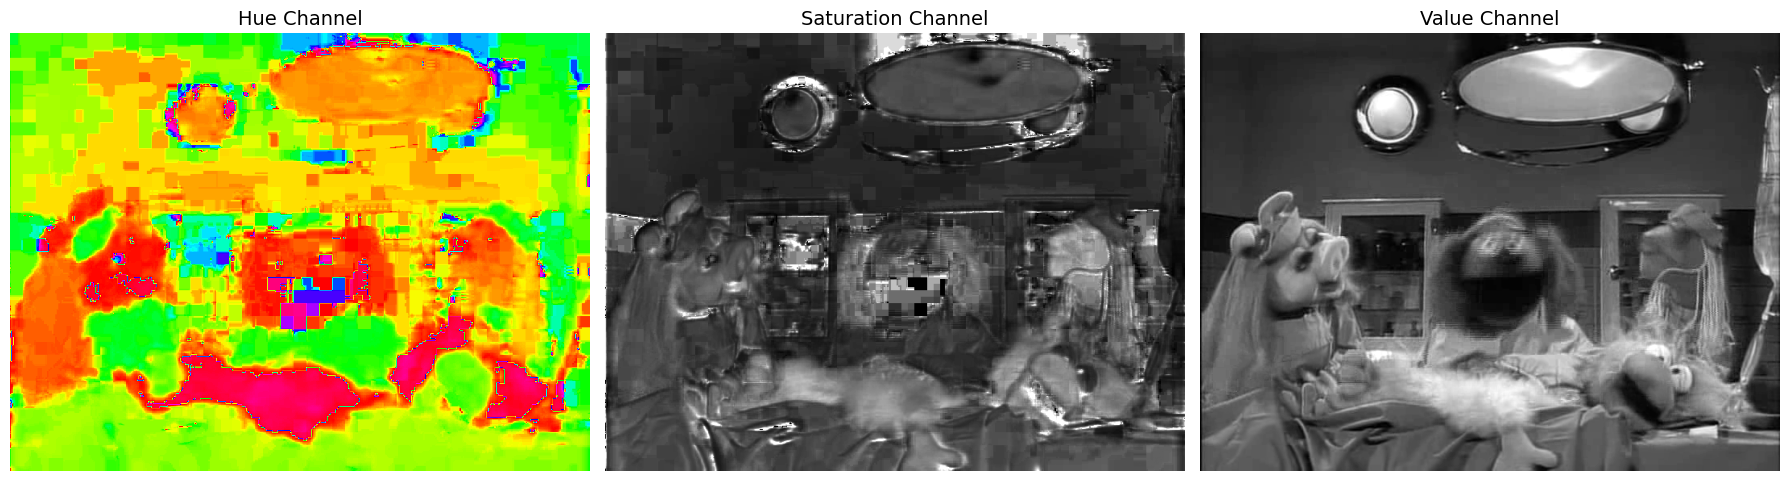

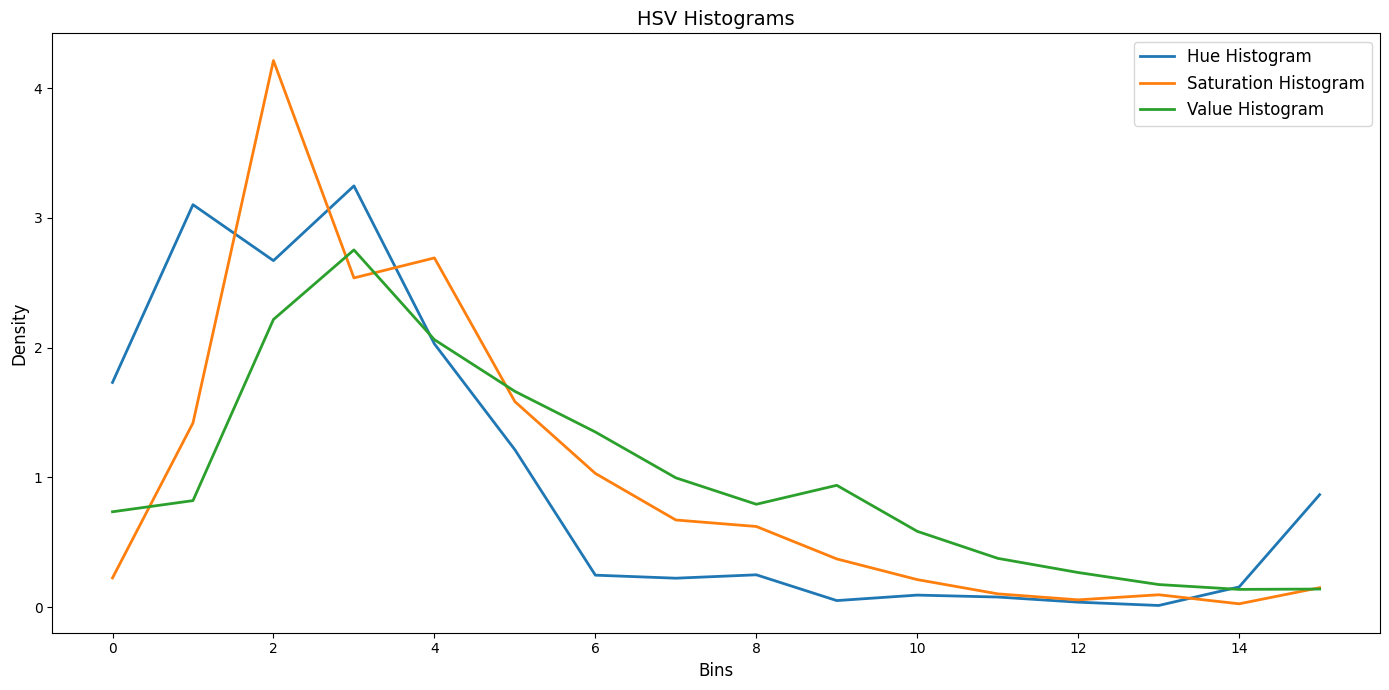

In [37]:
from scripts.extract_video_features import visualize_hsv

frame_path = "../ground_truth_data/frames\\Muppets-02-01-01_frame18799.png"  # Replace with your frame path
frame = imread(frame_path)

# Visualize hsv
visualize_hsv(frame)


## Model Prep

Load Ground Truth and merge it with the feature dataframe.

In [38]:
# Merge DataFrames on 'video_idx' and 'frame_idx'
#merged_df = lbp_features_df.merge(dct_features_df, on=["video_idx", "frame_idx"], how="inner")
#merged_df = merged_df.merge(hsv_feature_df, on=["video_idx", "frame_idx"], how="inner")

output_path_merged = "../model_vars/sim2_video/merged_df.csv"
#merged_df.to_csv(output_path_merged, index=False)

merged_df = pd.read_csv(output_path_merged)
merged_df.shape

(115885, 124)

In [39]:
# Create a mapping from filenames to video indices
video_idx_map = {filename: idx for idx, filename in enumerate(muppet_files.keys())}

# Prepare ground truth data with corrected video_idx
ground_truth_data = []
for video_filename, annotation_df in annotations.items():
    video_idx = video_idx_map[video_filename]  # Map video filename to its index
    for _, row in annotation_df.iterrows():
        ground_truth_data.append({
            'video_idx': video_idx,  # Use mapped video index
            'frame_idx': row['Frame_number'],  
            'Pigs': row['Pigs'],  
            'Cook': row['Cook']  
        })

# Create a DataFrame for ground truth
ground_truth_df = pd.DataFrame(ground_truth_data)
ground_truth_df.shape

(115885, 4)

In [40]:
# Merge features with ground truth
feature_df = pd.merge(merged_df, ground_truth_df, on=['video_idx', 'frame_idx'], how='inner')
feature_df.shape

(115885, 126)

Partition the dataframe into folds (this will be discussed in the Train-Test-Split chapter).

In [41]:
# split_points = {
#     0: 19716,  # Video 0
#     1: 19719,  # Video 1
#     2: 19432, # Video 2 
# }

# Assuming feature_df is the dataframe containing video_idx and frame_idx columns
grp_by = ['Pigs', 'Cook']
feature_df, split_overview = partition_feature_df(feature_df, grp_by = grp_by)

output_path_feature = "../model_vars/sim2_video/feature_df.csv"
feature_df.to_csv(output_path_feature, index=False)

#feature_df = pd.read_csv(output_path_feature)
feature_df.shape

(115885, 127)

In [14]:
feature_df.head()

,lbp_bin_0,lbp_bin_1,lbp_bin_2,lbp_bin_3,lbp_bin_4,lbp_bin_5,lbp_bin_6,lbp_bin_7,lbp_bin_8,lbp_bin_9,...,hsv_channel_2_bin_9,hsv_channel_2_bin_10,hsv_channel_2_bin_11,hsv_channel_2_bin_12,hsv_channel_2_bin_13,hsv_channel_2_bin_14,hsv_channel_2_bin_15,Pigs,Cook,fold
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0-A
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0-A
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0-A
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0-A
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0-A


In [15]:
# Display the results
print(split_overview)

feature_df['fold'].unique() # ACHTUNG manche fehlen in den Splits!

   video_idx fold  Pigs  Cook
0          0  0-A  1871   217
1          0  0-B     0  1654
2          1  1-A  4012   226
3          1  1-B  4769     0
4          2  2-A  5134   683
5          2  2-B  5694   665


array(['0-A', '0-B', '1-A', '1-B', '2-A', '2-B'], dtype=object)

In [16]:
# Select only numeric columns
numeric_df = feature_df.select_dtypes(include=[np.number])


print("NaN in any feature:", feature_df.isnull().values.any())
# Check for infinite values in numeric columns
print("Inf in any numeric feature:", np.isinf(numeric_df.values).any())

# Optionally, find rows with infinite values
rows_with_inf = numeric_df[np.isinf(numeric_df).any(axis=1)].index.tolist()
print("Rows with Inf values:", rows_with_inf)

NaN in any feature: False
Inf in any numeric feature: False
Rows with Inf values: []


# Visual Classification

For the visual analysis we employ two different Algorithms - Naive Bayes and XGBoost. Due to limited computational resources, the parameter grids for these models were kept small.

In [17]:
import numpy as np
import pandas as pd

from scripts.nested_cv import evaluate_model, nested_cross_validation, ncv_xgb_gpu
import psutil
import os

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

physical_cores = psutil.cpu_count(logical=False)
print(f"Number of physical cores: {physical_cores}")

os.environ["LOKY_MAX_CPU_COUNT"] = "12"

Number of physical cores: 12


In [18]:
feature_df = pd.read_csv('../model_vars/sim2_video/feature_df.csv')

train_cols = [col for col in feature_df.columns if col.startswith(('lbp', 'hsv', 'dct'))]

In [19]:
feature_df.describe()

,lbp_bin_0,lbp_bin_1,lbp_bin_2,lbp_bin_3,lbp_bin_4,lbp_bin_5,lbp_bin_6,lbp_bin_7,lbp_bin_8,lbp_bin_9,...,hsv_channel_2_bin_8,hsv_channel_2_bin_9,hsv_channel_2_bin_10,hsv_channel_2_bin_11,hsv_channel_2_bin_12,hsv_channel_2_bin_13,hsv_channel_2_bin_14,hsv_channel_2_bin_15,Pigs,Cook
count,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,...,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000,115885.000000
mean,0.010907,0.038826,0.020460,0.085142,0.151472,0.230323,0.054135,0.047366,0.311475,0.049892,...,1.072261,0.953754,0.828437,0.712243,0.527304,0.338847,0.221629,0.203214,0.185356,0.029728
std,0.003762,0.011804,0.007544,0.023469,0.055371,0.049187,0.012952,0.011772,0.137520,0.013403,...,0.700995,0.902687,0.793313,0.822851,0.663433,0.460252,0.331332,0.443309,0.388588,0.169836
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.089293,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.008638,0.032616,0.015663,0.071089,0.114698,0.207644,0.047393,0.041565,0.210585,0.043814,...,0.598243,0.433292,0.297752,0.208333,0.115266,0.064257,0.033783,0.023061,0.000000,0.000000
50%,0.010828,0.038689,0.020450,0.087530,0.158467,0.231000,0.055560,0.048019,0.283731,0.049599,...,0.955637,0.771098,0.596925,0.417279,0.281822,0.186111,0.114890,0.086969,0.000000,0.000000
75%,0.013261,0.044996,0.025380,0.100518,0.194563,0.253705,0.062576,0.053682,0.375763,0.056000,...,1.350476,1.172585,0.972100,0.858088,0.646432,0.421650,0.268791,0.205025,0.000000,0.000000
max,0.042604,0.222249,0.049828,0.146134,0.271931,0.460948,0.090126,0.216194,1.000000,0.356191,...,7.688644,11.281291,6.124551,7.989216,4.902741,3.509804,4.298856,15.792565,1.000000,1.000000


In [20]:
print(train_cols)
len(train_cols)

['lbp_bin_0', 'lbp_bin_1', 'lbp_bin_2', 'lbp_bin_3', 'lbp_bin_4', 'lbp_bin_5', 'lbp_bin_6', 'lbp_bin_7', 'lbp_bin_8', 'lbp_bin_9', 'dct_coeff_0', 'dct_coeff_1', 'dct_coeff_2', 'dct_coeff_3', 'dct_coeff_4', 'dct_coeff_5', 'dct_coeff_6', 'dct_coeff_7', 'dct_coeff_8', 'dct_coeff_9', 'dct_coeff_10', 'dct_coeff_11', 'dct_coeff_12', 'dct_coeff_13', 'dct_coeff_14', 'dct_coeff_15', 'dct_coeff_16', 'dct_coeff_17', 'dct_coeff_18', 'dct_coeff_19', 'dct_coeff_20', 'dct_coeff_21', 'dct_coeff_22', 'dct_coeff_23', 'dct_coeff_24', 'dct_coeff_25', 'dct_coeff_26', 'dct_coeff_27', 'dct_coeff_28', 'dct_coeff_29', 'dct_coeff_30', 'dct_coeff_31', 'dct_coeff_32', 'dct_coeff_33', 'dct_coeff_34', 'dct_coeff_35', 'dct_coeff_36', 'dct_coeff_37', 'dct_coeff_38', 'dct_coeff_39', 'dct_coeff_40', 'dct_coeff_41', 'dct_coeff_42', 'dct_coeff_43', 'dct_coeff_44', 'dct_coeff_45', 'dct_coeff_46', 'dct_coeff_47', 'dct_coeff_48', 'dct_coeff_49', 'dct_coeff_50', 'dct_coeff_51', 'dct_coeff_52', 'dct_coeff_53', 'dct_coeff_54',

122

## Train-Test-Split Approach

In this analysis, we employ a nested cross-validation approach for our classification models. The nested cross-validation provides robust model evaluation by incorporating two levels of data splitting: an outer loop for testing model generalization and an inner loop for hyperparameter tuning. The outer loop ensures that the performance metrics reflect how well the model generalizes to entirely unseen data, while the inner loop systematically optimizes the model's parameters using the training data.

A traditional random train-test split could lead to data leakage if frames from the same video appear in both the training and testing sets. This overlap could inflate performance metrics by allowing the model to learn video-specific features rather than generalizable patterns. The nested cross-validation mitigates this risk by ensuring that the outer splits isolate data from different videos, providing a more realistic estimate of the model's ability to generalize across unseen scenarios. 

For the creation of the folds, each episode is split at its midway point, specifically at the transition where a segment ends and the screen briefly fades to black before the next segment begins. This results in two distinct folds per episode, ensuring that each fold captures a separate and coherent part of the episode. Unfortunately,  we have to omit a fold for both the Pigs (0-B) and the Swedish Cook (1-B), as we have no positive annotations for them. 

## Naive Bayes

#### Pigs

In [21]:
from sklearn.naive_bayes import GaussianNB

# Define parameter grid
param_grid = {}

feature_df_pigs = feature_df[feature_df['fold'] != "0-B"]

target_col = 'Pigs'
results_nb_pigs, summary_nb_pigs, best_model_nb_pigs = nested_cross_validation(
    feature_df_pigs, 
    train_cols, 
    target_col, 
    GaussianNB, 
    param_grid, 
    num_cores=10
)

## Save Vars
import pickle
with open('../model_vars/sim2_video/pigs_nb_results.pkl', 'wb') as f:
    pickle.dump({
        'results_pigs': results_nb_pigs,
        'summary_pigs': summary_nb_pigs,
        'best_model_pigs': best_model_nb_pigs
    }, f)



Metrics for Fold 0-A: {'outer_fold': '0-A', 'accuracy': 0.5234327449786975, 'precision': np.float64(0.1526174868433201), 'recall': np.float64(0.8834847675040085), 'f1': np.float64(0.2602739726027397), 'roc_auc': np.float64(0.8487717815939532)}
Metrics for Fold 1-A: {'outer_fold': '1-A', 'accuracy': 0.6932907348242812, 'precision': np.float64(0.3551508252703472), 'recall': np.float64(0.6221335992023929), 'f1': np.float64(0.45217391304347826), 'roc_auc': np.float64(0.7155395959571467)}
Metrics for Fold 1-B: {'outer_fold': '1-B', 'accuracy': 0.6257965976720914, 'precision': np.float64(0.2798718431963815), 'recall': np.float64(0.31138603480813587), 'f1': np.float64(0.29478908188585606), 'roc_auc': np.float64(0.6427215747031788)}
Metrics for Fold 2-A: {'outer_fold': '2-A', 'accuracy': 0.49639769452449567, 'precision': np.float64(0.3154846898302396), 'recall': np.float64(0.7746396571873783), 'f1': np.float64(0.4483652762119504), 'roc_auc': np.float64(0.7358976928458588)}
Metrics for Fold 2-B

### Swedish Cook

In [22]:
# Define parameter grid
param_grid = {}

feature_df_cook = feature_df[feature_df['fold'] != "1-B"]

target_col = 'Cook'
results_nb_cook, summary_nb_cook, best_model_nb_cook = nested_cross_validation(
    feature_df_cook, 
    train_cols, 
    target_col, 
    GaussianNB, 
    param_grid, 
    num_cores=10
)


## Save Vars
import pickle
with open('../model_vars/sim2_video/cook_nb_results.pkl', 'wb') as f:
    pickle.dump({
        'results_cook': results_nb_cook,
        'summary_cook': summary_nb_cook,
        'best_model_cook': best_model_nb_cook
    }, f)

Metrics for Fold 0-A: {'outer_fold': '0-A', 'accuracy': 0.9831101643335363, 'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'roc_auc': np.float64(0.7417421618927403)}
Metrics for Fold 0-B: {'outer_fold': '0-B', 'accuracy': 0.9077247561297126, 'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'roc_auc': np.float64(0.9156154738580365)}
Metrics for Fold 1-A: {'outer_fold': '1-A', 'accuracy': 0.9406663623916021, 'precision': np.float64(0.06697247706422019), 'recall': np.float64(0.3230088495575221), 'f1': np.float64(0.11094224924012158), 'roc_auc': np.float64(0.8414041527954895)}
Metrics for Fold 2-A: {'outer_fold': '2-A', 'accuracy': 0.8222519555372582, 'precision': np.float64(0.013005272407732865), 'recall': np.float64(0.05417276720351391), 'f1': np.float64(0.020975056689342405), 'roc_auc': np.float64(0.6326220463334423)}
Metrics for Fold 2-B: {'outer_fold': '2-B', 'accuracy': 0.851201090947236, 'precision': np.float64(0.0), 'r

## XGBoost

In [23]:
import torch
from scripts.nested_cv import ncv_xgb_gpu

if torch.cuda.is_available():
    print(f"CUDA is available. GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")


CUDA is available. GPU: NVIDIA GeForce RTX 4070 Ti SUPER


### Pigs

In [24]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}

feature_df_pigs = feature_df[feature_df['fold'] != "0-B"]
feature_df_pigs.shape

feature_df = pd.read_csv('../model_vars/sim2_video/feature_df.csv')
train_cols = [col for col in feature_df.columns if col.startswith(('lbp', 'hsv', 'dct'))]

target_col='Pigs'
results_xgb_pigs, summary_xgb_pigs, best_models_xgb_pigs = ncv_xgb_gpu(
    feature_df=feature_df_pigs,
    train_cols=train_cols,
    target_col=target_col,
    param_grid=param_grid
)


## Save Vars
import pickle
with open('../model_vars/sim2_video/pigs_xgb_results.pkl', 'wb') as f:
    pickle.dump({
        'results_pigs': results_xgb_pigs,
        'summary_pigs': summary_xgb_pigs,
        'best_model_pigs': best_models_xgb_pigs
    }, f)

Outer Fold: 0-A
Outer Fold: 1-A
Outer Fold: 1-B
Outer Fold: 2-A
Outer Fold: 2-B
Model: 6/6
Summary of Metrics Across Folds:
{'accuracy': 0.7550947403613891, 'precision': 0.3932261054110127, 'recall': 0.1396923236749566, 'f1': 0.19059350939844696, 'roc_auc': 0.6606317907768406}


### Swedish Cook

In [25]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}

feature_df_cook = feature_df[feature_df['fold'] != "1-B"]
feature_df_cook.shape

feature_df = pd.read_csv('../model_vars/sim2_video/feature_df.csv')
train_cols = [col for col in feature_df.columns if col.startswith(('lbp', 'hsv', 'dct'))]

target_col='Cook'
results_xgb_cook, summary_xgb_cook, best_models_xgb_cook = ncv_xgb_gpu(
    feature_df=feature_df_cook,
    train_cols=train_cols,
    target_col=target_col,
    param_grid=param_grid
)


## Save Vars
import pickle
with open('../model_vars/sim2_video/cook_xgb_results.pkl', 'wb') as f:
    pickle.dump({
        'results_cook': results_xgb_cook,
        'summary_cook': summary_xgb_cook,
        'best_model_cook': best_models_xgb_cook
    }, f)

Outer Fold: 0-A
Outer Fold: 0-B
Outer Fold: 1-A
Outer Fold: 2-A
Outer Fold: 2-B
Model: 6/6
Summary of Metrics Across Folds:
{'accuracy': 0.963794507992801, 'precision': 0.48120693715963186, 'recall': 0.3904074273922917, 'f1': 0.3851576241529083, 'roc_auc': 0.812835045705427}


## Evaluation

In [4]:
from scripts.nested_cv import evaluate_model
import os
import psutil
import pandas as pd

feature_df = pd.read_csv('../model_vars/sim2_video/feature_df.csv')
feature_df_pigs = feature_df[feature_df['fold'] != "0-B"]
feature_df_cook = feature_df[feature_df['fold'] != "1-B"]
train_cols = [col for col in feature_df.columns if col.startswith(('lbp', 'hsv', 'dct'))]


physical_cores = psutil.cpu_count(logical=False)
print(f"Number of physical cores: {physical_cores}")

os.environ["LOKY_MAX_CPU_COUNT"] = "12"

Number of physical cores: 12


### Naive Bayes

In [8]:
# load if necessary

import pickle

# Load Statler results
with open('../model_vars/sim2_video/pigs_nb_results.pkl', 'rb') as f:
    pigs_data = pickle.load(f)
    results_nb_pigs = pigs_data['results_pigs']
    summary_nb_pigs = pigs_data['summary_pigs']
    best_models_nb_pigs = pigs_data['best_model_pigs']

# Load Kermit results
with open('../model_vars/sim2_video/cook_nb_results.pkl', 'rb') as f:
    cook_data = pickle.load(f)
    results_nb_cook = cook_data['results_cook']
    summary_nb_cook = cook_data['summary_cook']
    best_model_nb_cook = cook_data['best_model_cook']



#### Pigs

In [28]:
results_nb_pigs

,outer_fold,accuracy,precision,recall,f1,roc_auc
0,0-A,0.523433,0.152617,0.883485,0.260274,0.848772
1,1-A,0.693291,0.355151,0.622134,0.452174,0.715540
2,1-B,0.625797,0.279872,0.311386,0.294789,0.642722
3,2-A,0.496398,0.315485,0.774640,0.448365,0.735898
4,2-B,0.487517,0.273324,0.431682,0.334718,0.484879


Fold 0-A Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.49      0.65     17845
           1       0.15      0.88      0.26      1871

    accuracy                           0.52     19716
   macro avg       0.56      0.68      0.45     19716
weighted avg       0.90      0.52      0.61     19716



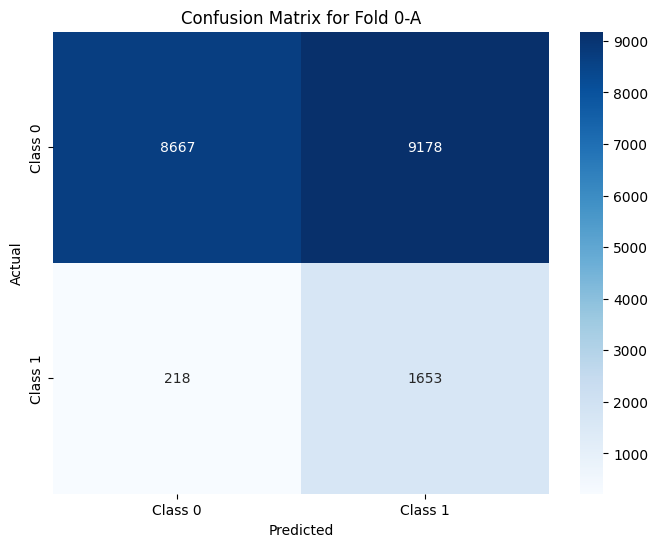

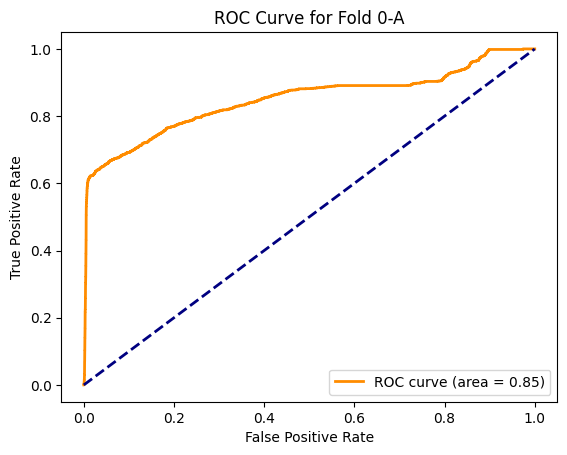

In [29]:
evaluate_model(best_model_nb_pigs, feature_df, train_cols, 'Pigs', results_nb_pigs, spec_fold= "best")

Fold 2-B Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.51      0.58     13372
           1       0.27      0.43      0.33      5694

    accuracy                           0.49     19066
   macro avg       0.48      0.47      0.46     19066
weighted avg       0.56      0.49      0.51     19066



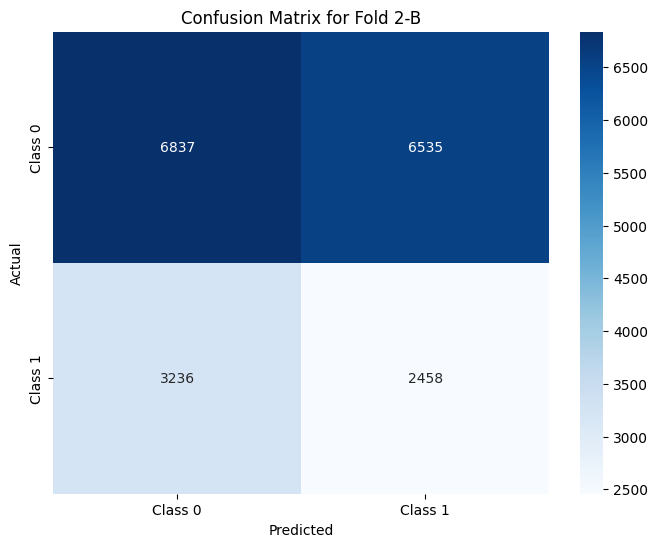

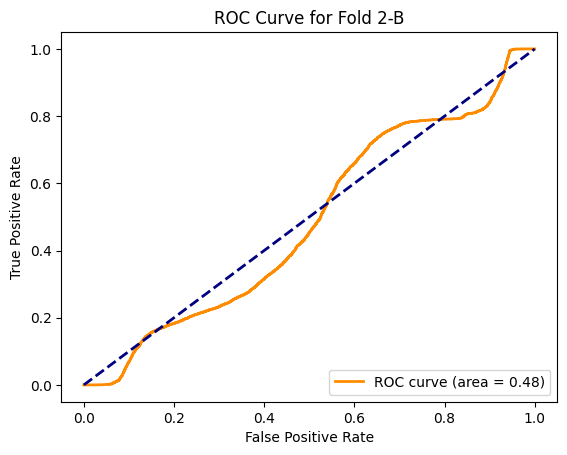

In [30]:
evaluate_model(best_model_nb_pigs, feature_df, train_cols, 'Pigs', results_nb_pigs, spec_fold= "worst")

#### Swedish Cook

In [31]:
results_nb_cook

,outer_fold,accuracy,precision,recall,f1,roc_auc
0,0-A,0.983110,0.000000,0.000000,0.000000,0.741742
1,0-B,0.907725,0.000000,0.000000,0.000000,0.915615
2,1-A,0.940666,0.066972,0.323009,0.110942,0.841404
3,2-A,0.822252,0.013005,0.054173,0.020975,0.632622
4,2-B,0.851201,0.000000,0.000000,0.000000,0.614761


In [12]:
results_xgb_cook

,outer_fold,accuracy,precision,recall,f1,roc_auc
0,0-A,0.997718,0.947917,0.838710,0.889976,0.999739
1,0-B,0.912787,NaN,0.000000,0.000000,0.614831
2,1-A,0.994624,0.715827,0.880531,0.789683,0.995301
3,2-A,0.949876,0.261084,0.232796,0.246130,0.630150
4,2-B,0.963967,0.000000,0.000000,0.000000,0.824154


Fold 0-B Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     17311
           1       0.00      0.00      0.00      1654

    accuracy                           0.91     18965
   macro avg       0.46      0.50      0.48     18965
weighted avg       0.83      0.91      0.87     18965



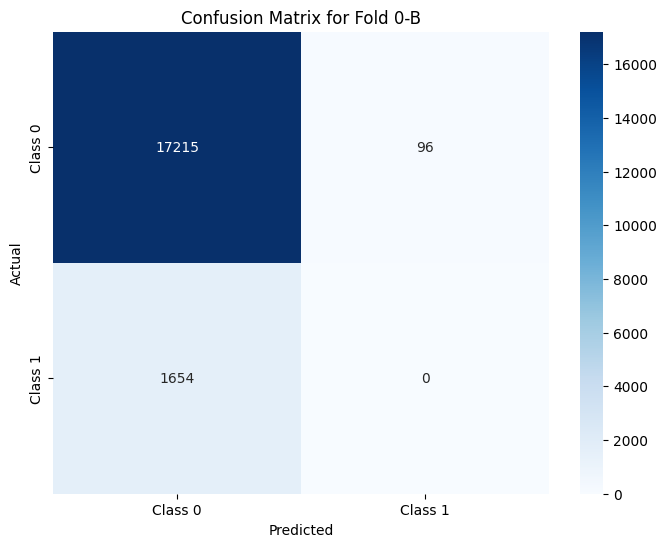

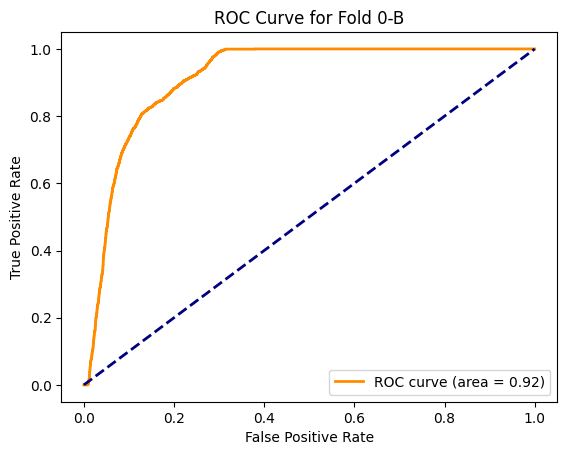

In [32]:
evaluate_model(best_model_nb_cook, feature_df, train_cols, 'Cook', results_nb_cook, spec_fold= "best")

              precision    recall  f1-score   support

     Class 0       0.99      0.95      0.97     19493
     Class 1       0.07      0.32      0.11       226

    accuracy                           0.94     19719
   macro avg       0.53      0.64      0.54     19719
weighted avg       0.98      0.94      0.96     19719

Confusion Matrix:
[[18476  1017]
 [  153    73]]


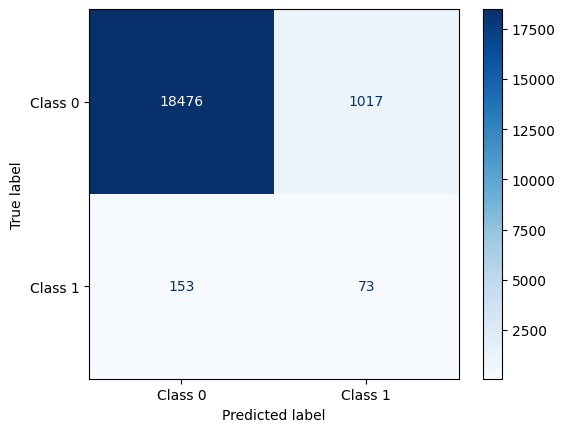

In [ ]:
# Take a look at the actual best fold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fold = '1-A'
fold_data = feature_df[feature_df['fold'] == fold]
X_fold = fold_data[train_cols].values  # Features for the fold
y_fold = fold_data['Cook'].values  # True labels for the fold


y_pred = best_model_nb_cook[fold].predict(X_fold)
report = classification_report(y_fold, y_pred, target_names=['Class 0', 'Class 1'])
print(report)

# Generate the confusion matrix
cm = confusion_matrix(y_fold, y_pred)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues')

Fold 2-B Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92     18401
           1       0.00      0.00      0.00       665

    accuracy                           0.85     19066
   macro avg       0.48      0.44      0.46     19066
weighted avg       0.93      0.85      0.89     19066



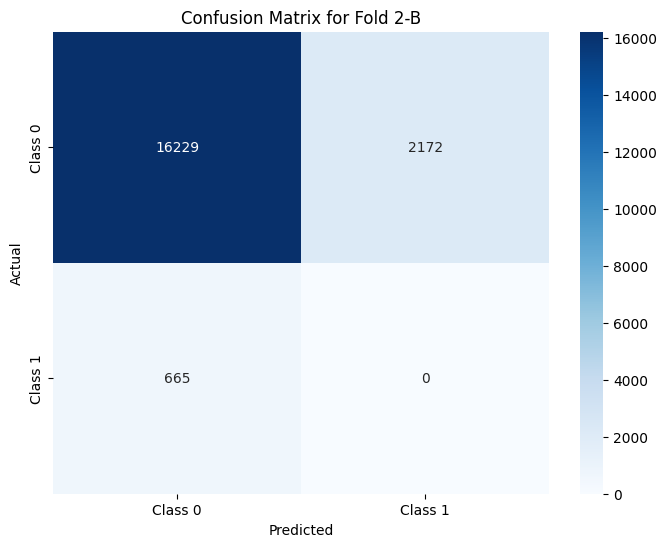

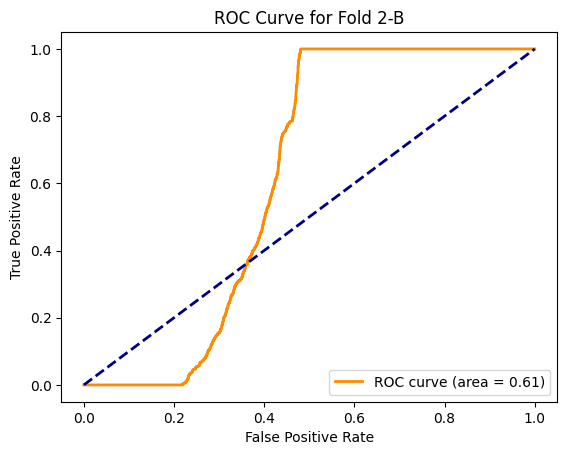

In [33]:
evaluate_model(best_model_nb_cook, feature_df, train_cols, 'Cook', results_nb_cook, spec_fold= "worst")

### XGBoost

In [9]:
# load if necessary

import pickle
import pandas as pd

# Load Statler results
with open('../model_vars/sim2_video/pigs_xgb_results.pkl', 'rb') as f:
    pigs_data = pickle.load(f)
    results_xgb_pigs = pigs_data['results_pigs']
    summary_xgb_pigs = pigs_data['summary_pigs']
    best_models_xgb_pigs = pigs_data['best_model_pigs']

# Load Kermit results
with open('../model_vars/sim2_video/cook_xgb_results.pkl', 'rb') as f:
    cook_data = pickle.load(f)
    results_xgb_cook = cook_data['results_cook']
    summary_xgb_cook = cook_data['summary_cook']
    best_model_xgb_cook = cook_data['best_model_cook']



#### Pigs

In [35]:
results_xgb_pigs

,outer_fold,accuracy,precision,recall,f1,roc_auc
0,0-A,0.859505,0.156083,0.109033,0.128383,0.699274
1,1-A,0.737258,0.307920,0.233549,0.265627,0.754427
2,1-B,0.786854,0.952381,0.159363,0.273038,0.761541
3,2-A,0.729158,0.468022,0.183872,0.264019,0.677030
4,2-B,0.662698,0.081725,0.012645,0.021901,0.410887


Fold 1-B Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     14218
           1       0.95      0.16      0.27      4769

    accuracy                           0.79     18987
   macro avg       0.87      0.58      0.57     18987
weighted avg       0.82      0.79      0.72     18987



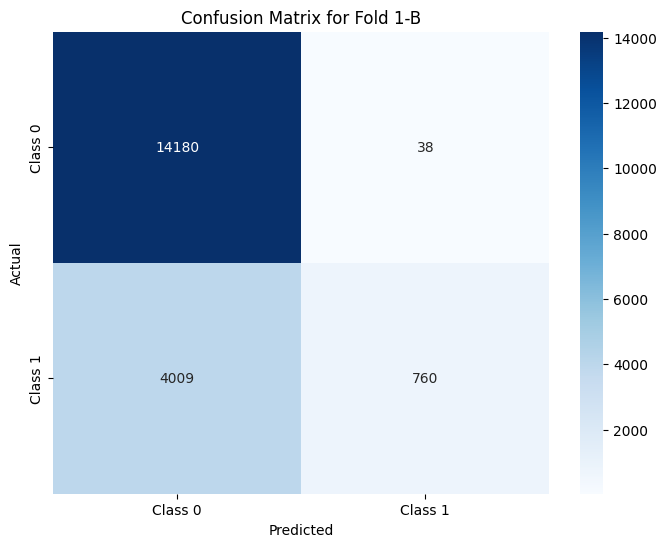

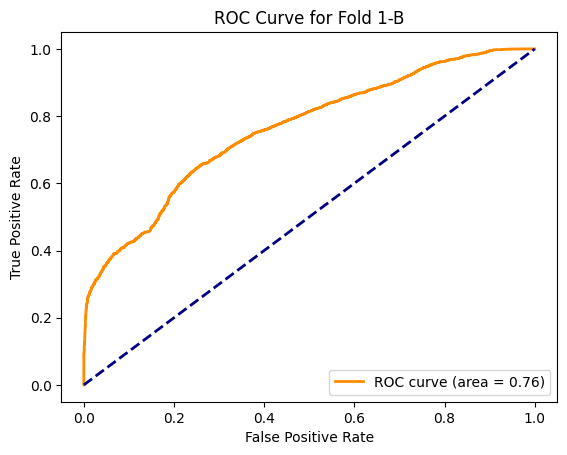

In [36]:
evaluate_model(best_models_xgb_pigs, feature_df, train_cols, 'Pigs', results_xgb_pigs, spec_fold= "best")

Fold 2-B Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.94      0.80     13372
           1       0.08      0.01      0.02      5694

    accuracy                           0.66     19066
   macro avg       0.39      0.48      0.41     19066
weighted avg       0.51      0.66      0.56     19066



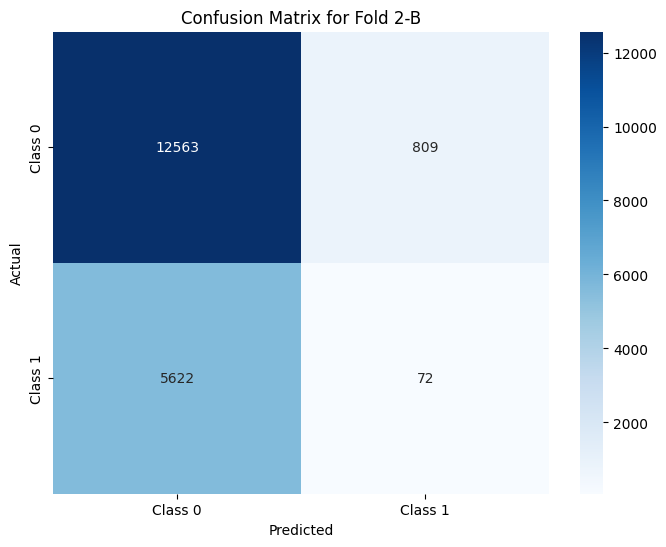

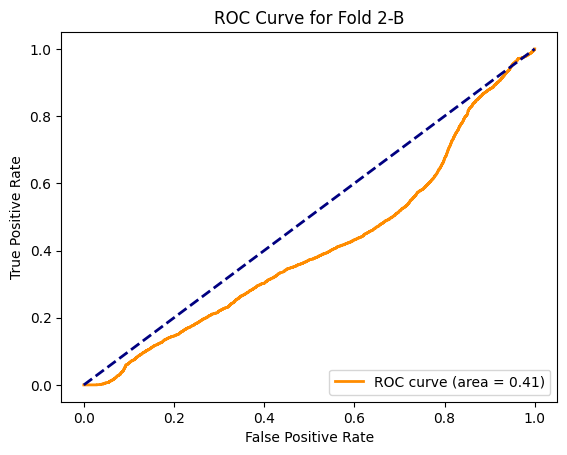

In [37]:
evaluate_model(best_models_xgb_pigs, feature_df, train_cols, 'Pigs', results_xgb_pigs, spec_fold= "worst")

#### Swedish Cook

In [38]:
results_xgb_cook

,outer_fold,accuracy,precision,recall,f1,roc_auc
0,0-A,0.997718,0.947917,0.838710,0.889976,0.999739
1,0-B,0.912787,NaN,0.000000,0.000000,0.614831
2,1-A,0.994624,0.715827,0.880531,0.789683,0.995301
3,2-A,0.949876,0.261084,0.232796,0.246130,0.630150
4,2-B,0.963967,0.000000,0.000000,0.000000,0.824154


Fold 0-A Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19499
           1       0.95      0.84      0.89       217

    accuracy                           1.00     19716
   macro avg       0.97      0.92      0.94     19716
weighted avg       1.00      1.00      1.00     19716



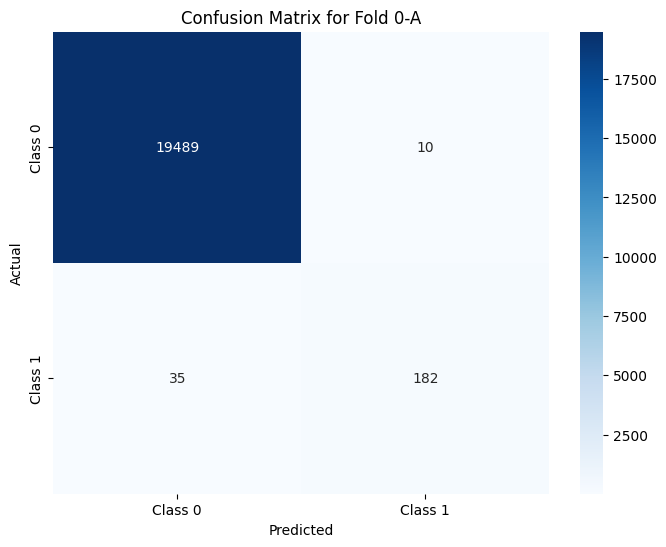

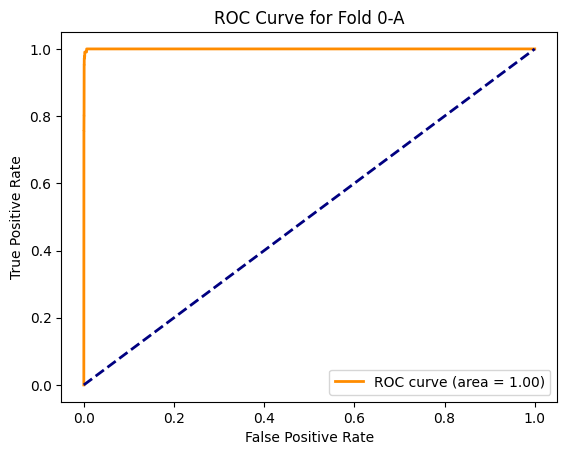

In [39]:
evaluate_model(best_model_xgb_cook, feature_df, train_cols, 'Cook', results_xgb_cook, spec_fold= "best")

Fold 0-B Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     17311
           1       0.00      0.00      0.00      1654

    accuracy                           0.91     18965
   macro avg       0.46      0.50      0.48     18965
weighted avg       0.83      0.91      0.87     18965



c:\Users\Mocca\anaconda3\envs\sim1_2\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Mocca\anaconda3\envs\sim1_2\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Mocca\anaconda3\envs\sim1_2\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


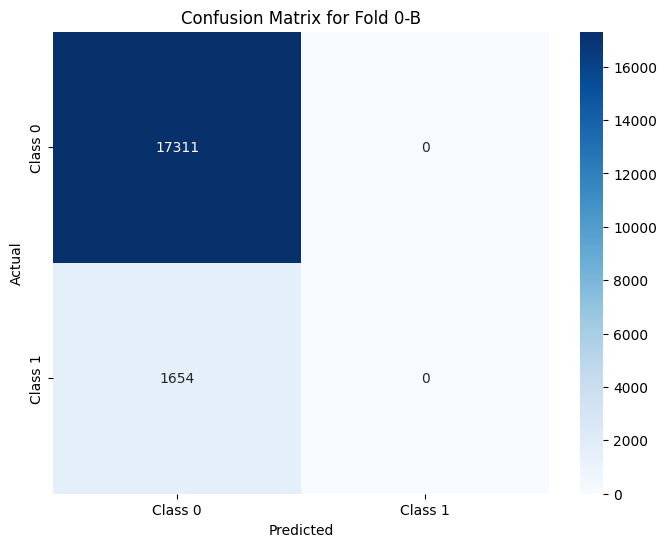

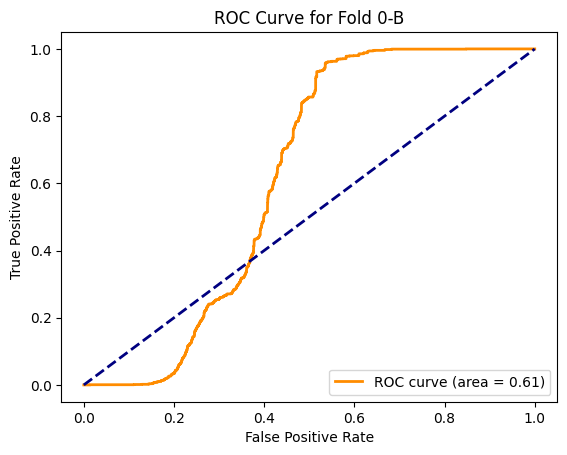

In [40]:
evaluate_model(best_model_xgb_cook, feature_df, train_cols, 'Cook', results_xgb_cook, spec_fold= "worst")

### Feature Importance

<Figure size 1200x800 with 0 Axes>

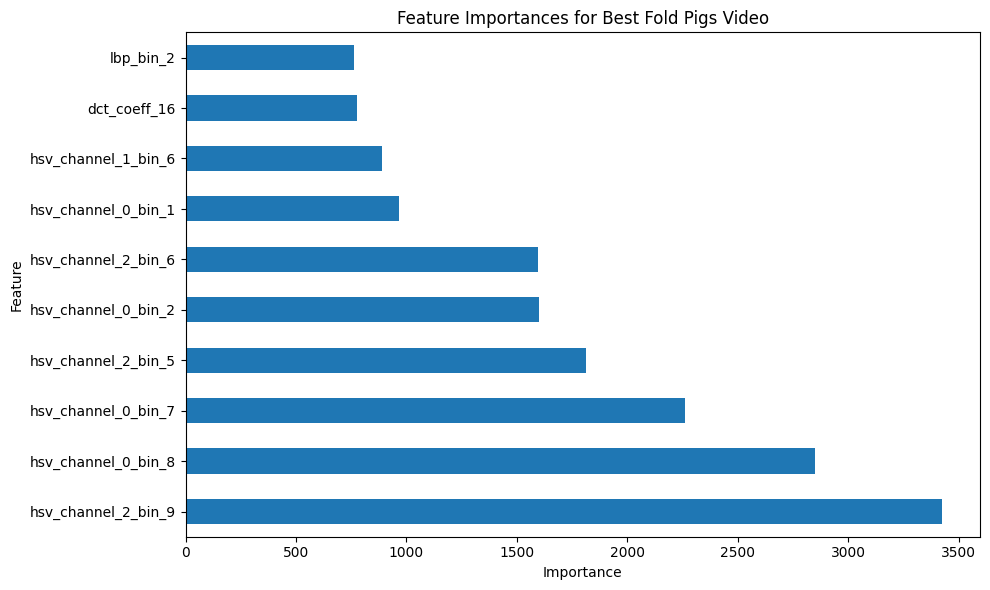

<Figure size 1200x800 with 0 Axes>

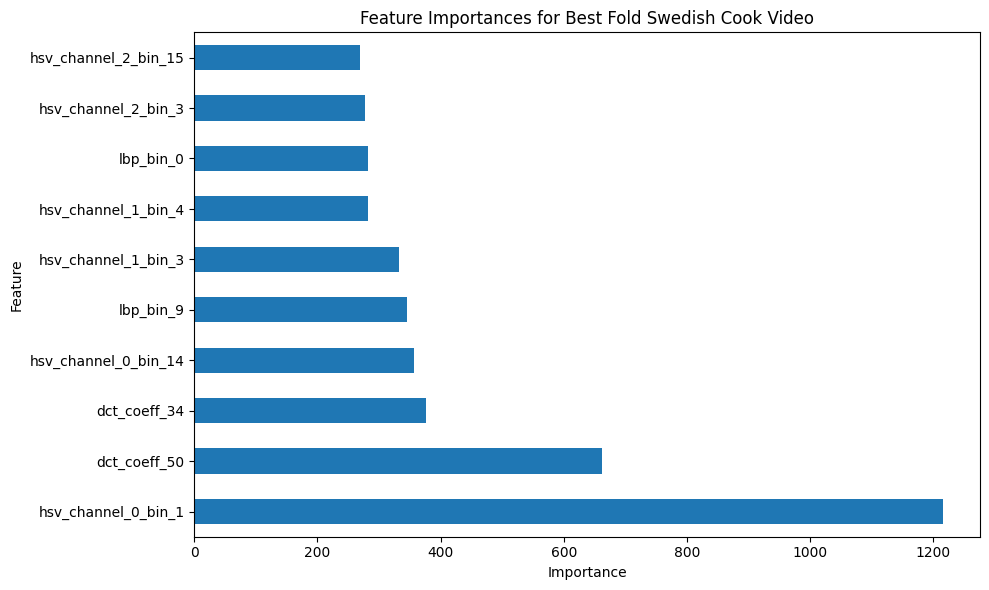

In [41]:
from scripts.nested_cv import plot_feature_importances 

# Pigs
plot_feature_importances(best_models_xgb_pigs, feature_df, train_cols, results_xgb_pigs, name= "Pigs Video", n= 10)

# Cook
plot_feature_importances(best_model_xgb_cook, feature_df, train_cols, results_xgb_cook, name= "Swedish Cook Video", n= 10)

## Conclusion

For pig detection, the Naive Bayes model demonstrates a more consistent AUC performance across all folds compared to XGBoost. In many folds, the precision and recall metrics of Naive Bayes surpass those of XGBoost for the same folds. Across all models, fold 2-B consistently emerges as the worst-performing fold, exhibiting the lowest AUC. Interestingly, Naive Bayes and XGBoost identify different folds as their best-performing ones: Naive Bayes achieves its best performance on fold 0-A, while XGBoost performs best on fold 0-B.
Feature importance analysis unsurprisingly highlights HSV features as the most influential for pig detection. Among the top 10 features, HSV features dominate, with only one DCT feature and one LBP feature making it into the top 10. This dominance is likely due to the pigs’ distinctive colors, which provide a strong basis for classification.


| Audio Results Pigs        | Accuracy   | Precision  | Recall     | F1        | ROC AUC   |
|---------------------------|------------|------------|------------|-----------|-----------|
| **Naive Bayes - Overall** | 0.5653     | 0.2753     | 0.6047     | 0.3581    | 0.6856    |
| **XGBoost - Overall**     | 0.7551     | 0.3932     | 0.1397     | 0.1906    | 0.6606    |
| **Naive Bayes - Best Fold** | 0.5234    | 0.1526     | 0.8835     | 0.2603    | 0.8488    |
| **XGBoost - Best Fold**   | 0.7869     | 0.9524     | 0.1594     | 0.2730    | 0.7615    |

For the Swedish Cook, both models struggle significantly with class imbalance. Compared to the pig detection task, XGBoost demonstrates better overall performance across all folds for this task. As before, fold 2-B emerges as the worst-performing fold for Naive Bayes, while for XGBoost, fold 0-B performs the worst. Interestingly, similar to the Similarity Modeling 1 project, fold 2-A is particularly challenging, as the majority of characters in that episode are dressed up, adding complexity to the classification task.
A closer examination of the classification report and metrics such as precision and recall reveals that the models often default to predicting the majority class. The best-performing folds are 0-B for Naive Bayes and 0-A for XGBoost. However, it is important to note that the best fold for Naive Bayes, based solely on voting, still predicts only the majority class. When ranking folds based on precision and recall, fold 1-A clearly outperforms for Naive Bayes.
HSV features dominate the feature importance for this task but account for only 6 of the top 10 features—significantly fewer compared to the pig detection task, where 8 out of the top 10 features were HSV-based. The remaining 4 features are evenly split between DCT and LBP, highlighting a more balanced contribution of these feature types compared to the dominance of HSV features.


| Audio Results Swedish Cook | Accuracy   | Precision  | Recall     | F1        | ROC AUC   |
|----------------------------|------------|------------|------------|-----------|-----------|
| **Naive Bayes - Overall**  | 0.9010     | 0.0160     | 0.0754     | 0.0264    | 0.7492    |
| **XGBoost - Overall**      | 0.9638     | 0.4812     | 0.3904     | 0.3852    | 0.8128    |
| **Naive Bayes - Best Fold** | 0.9077    | 0.0000*    | 0.0000*    | 0.0000*   | 0.9156    |
| **Naive Bayes - Fold with highest Recall** | 0.9407  | 0.0670   | 0.3231   | 0.1110   | 0.8414    |
| **XGBoost - Best Fold**    | 0.9977     | 0.9479     | 0.8387     | 0.8900    | 0.9997    |


\* The Naive Bayes model for Swedish Cook in the best fold fails due to its inability to handle certain data characteristics effectively.